## EfficientNet V2 相较 V1 的改进点

* 网络架构搜索的损失函数考虑了精度,参数数量以及训练速度

* 浅层引入 Fused-MBConv 模块. 在浅层网络（Stage 1-3 或 Stage 1-4）中，将传统的 **MBConv 模块** 替换为 **Fused-MBConv**（融合倒置残差块），通过合并深度可分离卷积（Depthwise Conv）和扩展层操作，减少计算延迟并提升浅层特征提取效率

<img src="resources/efficientnetv2_block.png" alt="drawing" width="40%"/>

* 引入了Progressive Training的方法, 训练过程中逐步调整方法图像的大小,并逐步加大正则项控制模型复杂度

<img src="resources/efficientnetv2_pareto.png" alt="drawing" width="60%"/>


In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory

train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=None,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=None,
)

# 使用单一图像大小进行训练

In [3]:
from hdd.data_util.auto_augmentation import ImageNetPolicy

from torch.utils.data import DataLoader
from hdd.models.cnn.efficientnet import create_efficient_net
from hdd.train.classification_utils import (
    naive_train_classification_model,
)
from hdd.models.nn_utils import count_trainable_parameter

MAX_EPOCHES = 100
BATCH_SIZE = 32


def train_net(
    net,
    train_dataloader,
    val_dataloader,
    scheduler,
    optimizer,
    max_epochs=100,
) -> dict[str, list[float]]:
    print(f"#Parameter: {count_trainable_parameter(net)}")
    criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        verbose=True,
    )
    return training_stats


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader


# 我们提前计算好了训练数据集上的均值和方差
TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]
net, _, _ = create_efficient_net("efficientnet_v2_s", 0.5, 10)
net = net.to(DEVICE)

crop_size = 224
resize_size = crop_size + 30
train_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(resize_size),
        transforms.RandomCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        ImageNetPolicy(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
train_dataset.transform = train_dataset_transforms
val_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(resize_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
val_dataset.transform = val_dataset_transforms
train_dataloader, val_dataloader = build_dataloader(
    BATCH_SIZE, train_dataset, val_dataset
)
lr = 0.005
weight_decay = 1e-2
optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, MAX_EPOCHES, eta_min=lr / 100
)
one_size_stats = train_net(
    net,
    train_dataloader,
    val_dataloader,
    scheduler,
    optimizer,
    max_epochs=MAX_EPOCHES,
)

#Parameter: 20190298
Epoch: 1/100 Train Loss: 2.7455 Accuracy: 0.1044 Time: 16.69262  | Val Loss: 2.3202 Accuracy: 0.1022
Epoch: 2/100 Train Loss: 2.4209 Accuracy: 0.1098 Time: 16.62807  | Val Loss: 2.3295 Accuracy: 0.1307
Epoch: 3/100 Train Loss: 2.3527 Accuracy: 0.1312 Time: 16.37806  | Val Loss: 2.2494 Accuracy: 0.1857
Epoch: 4/100 Train Loss: 2.2598 Accuracy: 0.1766 Time: 16.35645  | Val Loss: 2.1056 Accuracy: 0.2395
Epoch: 5/100 Train Loss: 2.1671 Accuracy: 0.2291 Time: 16.59511  | Val Loss: 2.0084 Accuracy: 0.3118
Epoch: 6/100 Train Loss: 2.0891 Accuracy: 0.2738 Time: 16.62948  | Val Loss: 1.9040 Accuracy: 0.3870
Epoch: 7/100 Train Loss: 2.0156 Accuracy: 0.3204 Time: 16.63088  | Val Loss: 1.8478 Accuracy: 0.4245
Epoch: 8/100 Train Loss: 1.9281 Accuracy: 0.3736 Time: 16.69632  | Val Loss: 1.7659 Accuracy: 0.4494
Epoch: 9/100 Train Loss: 1.8819 Accuracy: 0.3951 Time: 17.03115  | Val Loss: 1.9621 Accuracy: 0.3811
Epoch: 10/100 Train Loss: 1.8324 Accuracy: 0.4174 Time: 16.87950  | Va

In [ ]:
net, _, _ = create_efficient_net("efficientnet_v2_s", 0.5, 10)
net = net.to(DEVICE)
crop_sizes = [128, 160, 192, 224]
weight_decays = [3e-3, 1e-3, 3e-2, 1e-2]
lr = 0.002
progressive_learning_stats = []
for crop_size, weight_decay in zip(crop_sizes, weight_decays):
    train_dataset_transforms = transforms.Compose(
        [
            transforms.Resize(crop_size + 30),
            transforms.RandomCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            ImageNetPolicy(),
            transforms.ToTensor(),
            transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
        ]
    )
    train_dataset.transform = train_dataset_transforms
    val_dataset_transforms = transforms.Compose(
        [
            transforms.Resize(crop_size + 30),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
        ]
    )
    val_dataset.transform = val_dataset_transforms
    train_dataloader, val_dataloader = build_dataloader(
        BATCH_SIZE, train_dataset, val_dataset
    )
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, MAX_EPOCHES // len(crop_sizes), eta_min=lr / 2.5
    )
    stats = train_net(
        net,
        train_dataloader,
        val_dataloader,
        scheduler,
        optimizer,
        max_epochs=MAX_EPOCHES // len(crop_sizes),
    )
    progressive_learning_stats.append(stats)
    lr = lr / 2.5

#Parameter: 20190298
Epoch: 1/25 Train Loss: 3.1068 Accuracy: 0.1185 Time: 9.02530  | Val Loss: 3.9094 Accuracy: 0.1210
Epoch: 2/25 Train Loss: 2.5543 Accuracy: 0.1364 Time: 9.16927  | Val Loss: 2.2154 Accuracy: 0.1990
Epoch: 3/25 Train Loss: 2.4415 Accuracy: 0.1746 Time: 9.19316  | Val Loss: 2.2969 Accuracy: 0.1982
Epoch: 4/25 Train Loss: 2.4267 Accuracy: 0.1747 Time: 8.84097  | Val Loss: 2.2542 Accuracy: 0.2318
Epoch: 5/25 Train Loss: 2.3877 Accuracy: 0.1939 Time: 9.25567  | Val Loss: 2.2947 Accuracy: 0.2540
Epoch: 6/25 Train Loss: 2.3379 Accuracy: 0.2060 Time: 8.96851  | Val Loss: 2.2267 Accuracy: 0.3039
Epoch: 7/25 Train Loss: 2.2778 Accuracy: 0.2441 Time: 9.08364  | Val Loss: 2.0426 Accuracy: 0.3090
Epoch: 8/25 Train Loss: 2.2652 Accuracy: 0.2520 Time: 9.03285  | Val Loss: 2.1540 Accuracy: 0.3101
Epoch: 9/25 Train Loss: 2.2413 Accuracy: 0.2535 Time: 9.06584  | Val Loss: 2.0088 Accuracy: 0.3266
Epoch: 10/25 Train Loss: 2.1209 Accuracy: 0.2909 Time: 9.05222  | Val Loss: 1.9242 Accur

In [7]:
progressive_learning_stat = {}
for field in one_size_stats.keys():
    progressive_learning_stat[field] = []
    for p in progressive_learning_stats:
        progressive_learning_stat[field].extend(p[field])

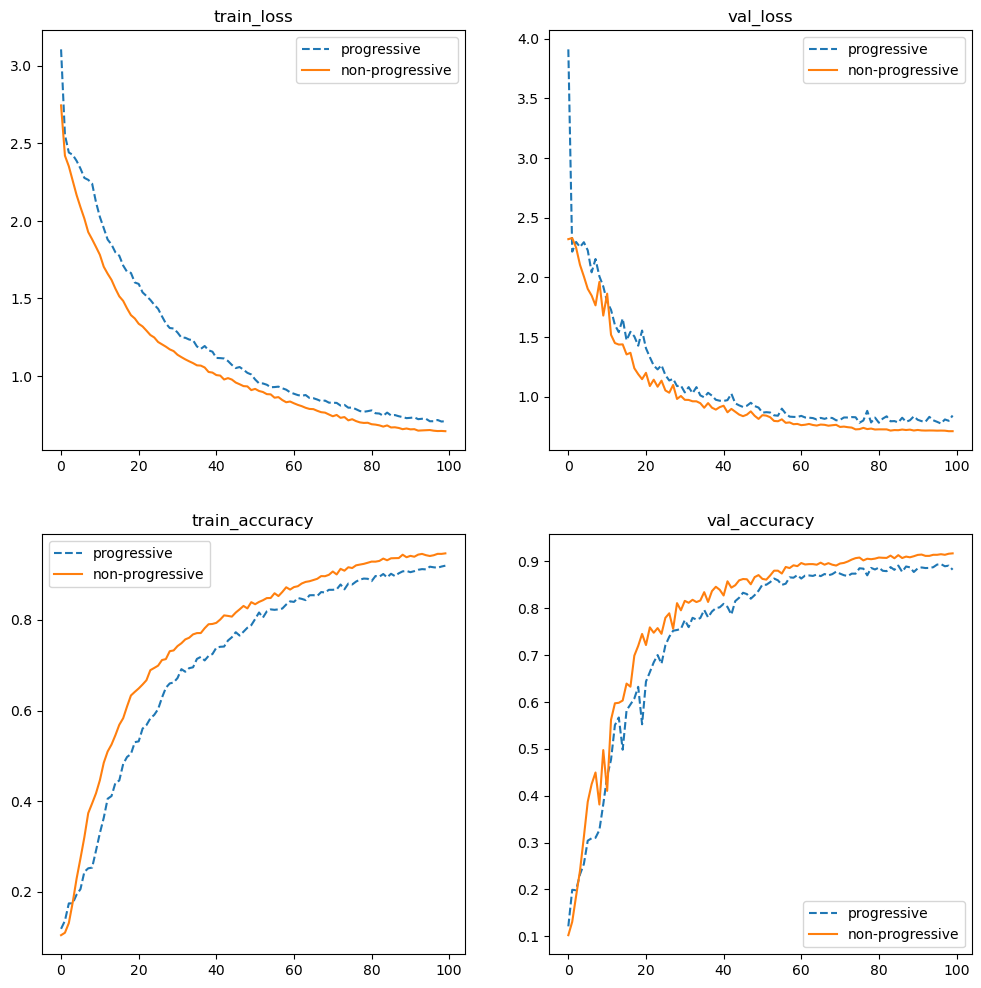

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = one_size_stats.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(progressive_learning_stat[field], label="progressive", linestyle="--")
    plt.plot(one_size_stats[field], label="non-progressive")
    plt.legend()
    plt.title(field)